### Use Natural Language Programming to determine the Risk tolerance of the client

In [1]:
# Ask the client about the perception of risk

PersonalStatementOnRisk = input('Enter your perception on risk: ')
print()

# Use Vader to calculate the polarity score sentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sa = SentimentIntensityAnalyzer()

sa.polarity_scores(PersonalStatementOnRisk)

# Use the Vader polarity score sentiment to determine which type of portfolio to construct for the client

CHOICE = [] 

if sa.polarity_scores(PersonalStatementOnRisk)['neg']>sa.polarity_scores(PersonalStatementOnRisk)['neu'] and sa.polarity_scores(PersonalStatementOnRisk)['neg']>sa.polarity_scores(PersonalStatementOnRisk)['pos']:
    
    print("Strategy: Propose Minimum Variance portfolio")
    CHOICE = -1
    
elif sa.polarity_scores(PersonalStatementOnRisk)['pos']>sa.polarity_scores(PersonalStatementOnRisk)['neu'] and sa.polarity_scores(PersonalStatementOnRisk)['pos']>sa.polarity_scores(PersonalStatementOnRisk)['neg']:
    
    print("Strategy: Propose Optimal Portfolio + Options Strategy ")
    
    CHOICE = 1
    
else:
    
    print("Strategy: Propose Optimal Portfolio")
    CHOICE = 0

Enter your perception on risk: I hate risk

Strategy: Propose Minimum Variance portfolio


### Ask the client the assets preferred for the portfolio

In [2]:
import re


ASSETS = []
Stock  = []

for i in range(10):
    
    Stock = input("Enter the ticker of the stock you are interested to add to your portfolio. Type 'Stop' when done...  ")
    Stock = re.sub(r'[^a-zA-Z]', '', Stock)
    Stock = Stock.lower()
    
    if Stock != "stop":
        
        Stock = Stock.upper()
        ASSETS.append(Stock)
        
    else:
        break    # break here
print()

tickers = ASSETS

Enter the ticker of the stock you are interested to add to your portfolio. Type 'Stop' when done...  tsla
Enter the ticker of the stock you are interested to add to your portfolio. Type 'Stop' when done...  goog
Enter the ticker of the stock you are interested to add to your portfolio. Type 'Stop' when done...  aapl
Enter the ticker of the stock you are interested to add to your portfolio. Type 'Stop' when done...  fb
Enter the ticker of the stock you are interested to add to your portfolio. Type 'Stop' when done...  baba
Enter the ticker of the stock you are interested to add to your portfolio. Type 'Stop' when done...  stop



In [3]:
# Importing all required libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from matplotlib.ticker import FuncFormatter

from pypfopt import objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns
#from pypfopt import plotting

from pypfopt.cla import CLA
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier

# library
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_7

# Risk free rate:

rf = 0.025

# Use an api to obtain a time series of a selected set of stocks, identified by their tickers.

#tickers = ['GOOG','AAPL','FB','BABA','AMZN','GE','AMD','WMT','BAC','GM','T','UAA','XOM','RRC','BBY','MA','PFE','JPM','SBUX']

price_data = []

start='2010-1-1'
end = '2021-12-31'

for ticker in tickers:
    
    prices = web.DataReader(ticker, 'stooq',start,end)
    
    price_data.append(prices.assign(ticker=ticker)[['Close']])
    
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers

df_stocks = df_stocks.sort_index()
df_stocks.head()

df_stocks.to_excel("df_stocks.xlsx")

# Obtain descriptive statistics of the sample

# Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)

# Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)



### Use the results from the Natural Language Processing to choose the ideal portfolio for the client

In [4]:
# Calculate the Sharpe ratio (mu/Sigma) of the different combinations of stocks within portfolios, and find those portfolios that have the highest Ratio given Sigma (efficient)

if CHOICE == 0:
    
    ef = EfficientFrontier(mu-rf, Sigma) 

    Portfolio = ef.max_sharpe() 
    
elif CHOICE == 1:
    
    ef = EfficientFrontier(mu-rf, Sigma, weight_bounds=(-1,1)) 

    Portfolio = ef.max_sharpe()     
    
else:
        
    ef = EfficientFrontier(mu-rf, Sigma, weight_bounds=(-1,1)) 

    Portfolio      = ef.min_volatility()
    
Portfolio_pwt  = ef.clean_weights()

print()
print("The weights among assets within the portfolio are:")    
ef.clean_weights()

Portf_t = list(Portfolio_pwt.keys())
Portf_w = list(Portfolio_pwt.values())

P_T = []
P_W = []

for i in range(len(Portf_t)):
    
    P_T.append(Portf_t[i])
    P_W.append(Portf_w[i])
    
PORTF   = pd.DataFrame(data=P_W,columns=['Weights'],index=P_T)
PORTpos = PORTF.loc[PORTF['Weights'] != 0]
PORTpos


The weights among assets within the portfolio are:


,Weights
TSLA,0.01393
GOOG,0.43214
AAPL,0.32043
FB,0.07145
BABA,0.16205


In [5]:
PERF = ef.portfolio_performance(verbose=True)

print()
print("The annual performance statistics of the portfolio are:")  

d = {"Annual Return":PERF[0],"Annual Volatility":PERF[1],"Sharpe Ratio":PERF[2]}

Performance = pd.DataFrame(data=d,index=["Values"])
Performance

Expected annual return: 21.1%
Annual volatility: 23.2%
Sharpe Ratio: 0.82

The annual performance statistics of the portfolio are:


,Annual Return,Annual Volatility,Sharpe Ratio
Values,0.21106,0.23188,0.823961


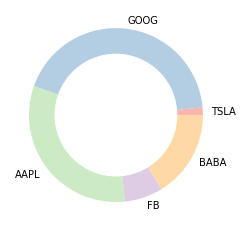

In [6]:
# create data
names = list(PORTpos.index)
size  = list(PORTpos.Weights)
size =  [abs(s) for s in size]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

from palettable.colorbrewer.qualitative import Pastel1_7
plt.pie(size, labels=names, colors=Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.savefig("chart.png", format="png") # specify filetype explicitly

plt.show()
plt.close()

In [7]:
# 1. Set up multiple variables to store the titles, text within the report
page_title_text='My report'
title_text = 'Recommended Portfolio'
text = 'Find below your optimal portfolio based on your risk profile and recent market conditions'
stats_text = 'Percentage of optimal portfolio on individual stocks'
perf_text  = 'Performance of optimal portfolio'


# 2. Combine them together using a long f-string
html = f'''
    <html>
        <head>
            <title>{page_title_text}</title>
        </head>
        <body>
            <h1>{title_text}</h1>
            <p>{text}</p>
            <img src='chart.png' width="700">
            <h2>{perf_text}</h2>
            {Performance.to_html()}
            <h2>{stats_text}</h2>
            {PORTF.to_html()}
        </body>
    </html>
    '''
# 3. Write the html string as an HTML file
with open('html_report.html', 'w') as f:
    f.write(html)